# Mars Figures de poles
* [Ponctuel](#ponctuel)

## Ponctuel<a name="ponctuel"></a>

rs = chi, and rz = phi, for each  of these positions, we made an omega scan in order to obtain a profile line of the scattered beam. We should have a peak, then we fit this peak with a given function. Then we just need to represent the value of this peak on the pole figuer at the rs, rz coordinate.

In [19]:
%matplotlib notebook

# first the imports
from typing import Iterator, List, NamedTuple, Optional, Text, Tuple

import os

import ipywidgets as widgets
import matplotlib

from matplotlib.pyplot import subplots, show

from numpy import array, ndarray
from h5py import Dataset, File

# local import
from soleil import Angle, Calibrant, Calibration, CalibrationFunctions, CalibrationFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathWithAttribute, get_dataset,\
    calibration, integrate, save_as_edf

In [2]:
# temporary until the ruch is ON
ROOT = os.path.join("/home", "experiences", "instrumentation", "picca", "jupyter", "mars", "20171282")

PUBLISHED = os.path.join(ROOT, "published-data")

In [23]:
# TODO add the data01, 8, 19, 24 a pole for each.
# 1 -> 1 1 0
# 8 -> 2 0 0
# 19 -> 2 2 0
# 24 - > 3 1 0
# a bunch of files seems to contain wrong dataset ???, we mark them as exculded, third member of the tuple

templates = [("Cr7R_T93-02_0p8dpa_text_CR_{}_01.nxs", list(range(164, 405)), [0]),
             ("Cr7R_T93-04_moniteur-thermique-400_C_text_CR_{}_01.nxs", list(range(1101, 1127)), [2, 4]),
             ("Cr7R_T93_reference_text_CR_{}_01.nxs", list(range(656, 907)), [0, 2, 4, 5, 6, 249]),
             ("Cr7V_T134-02_0p8dpa_text_CR_{}_01.nxs", list(range(405, 651)), [1, 3, 4, 5]),
             ("Cr7V_T134_reference_text_CR_{}_01.nxs",list(range(950, 1101)), [21, 22, 24, 28, 30, 54, 56, 57]),
             ("Cr7V_T194-01_0p1dpa_text_CR_{}_01.nxs",list(range(1279, 1299)), []),
             ("Cr7V_T194-01_0p1dpa_Zy-4_text_CR_{}_01.nxs", list(range(1299, 1330)), []),
             ("E59_T029V_text_CR_{}_01.nxs", list(range(1372, 1389)), [])]

PoleSources = NamedTuple('PoleSources', [('filenames', List[Text]),  # name of the files
                                         ('tth_path', DatasetPath),
                                         ('chi_path', DatasetPath),
                                         ('phi_path', DatasetPath),
                                         ('intensity_path', DatasetPath)])

def mkPole(template: Tuple[str, List[int]]) -> PoleSources:
    filenames = [os.path.join(ROOT, template[0].format(i)) for ii, i in enumerate(template[1]) if ii not in template[2]]
    tth_path = DatasetPathContains("scan_data/actuator_1_1")
    chi_path = DatasetPathContains("D03-1-CX2__EX__GONIO-MT_Rs__#1/raw_value")
    phi_path = DatasetPathContains("D03-1-CX2__EX__GONIO-MT_Rz__#1/raw_value")
    intensity_path = DatasetPathContains("scan_data/data_01")
    return PoleSources(filenames, tth_path, chi_path, phi_path, intensity_path)

poles = [mkPole(t) for t in templates]

In [8]:
res = []
for pole in poles:
    phis = []
    chis = []
    intensities = []
    for filename in pole.filenames:
        with File(filename, mode='r') as f:
            print(filename)
            get_dataset(f, pole.tth_path)
            chi = get_dataset(f, pole.chi_path)[0]
            phi = get_dataset(f, pole.phi_path)[0]
            intensity = get_dataset(f, pole.intensity_path)[:]
            
            phis.append(phi)
            chis.append(chi)
            intensities.append(intensity)
    res.append((array(phis), array(chis), intensities))
                  

/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_164_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_165_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_166_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_167_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_168_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_169_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_170_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_171_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_172_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_173_01.nxs


## plot the spectra

<IPython.core.display.Javascript object>


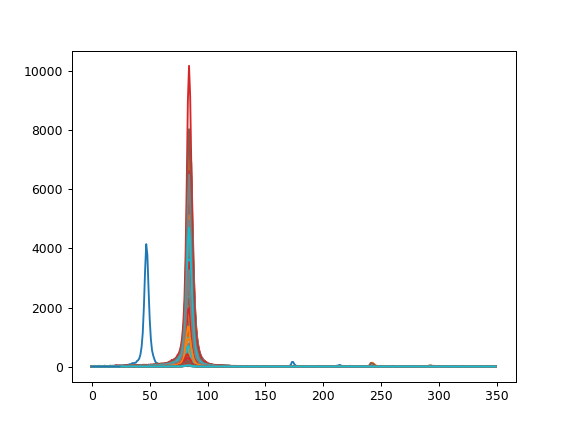

0
None


<IPython.core.display.Javascript object>


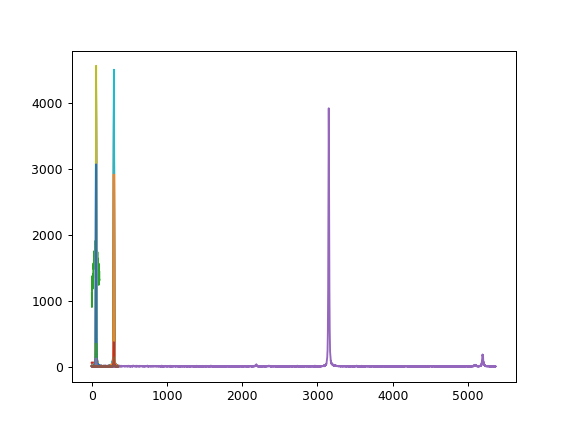

2
4
None


<IPython.core.display.Javascript object>


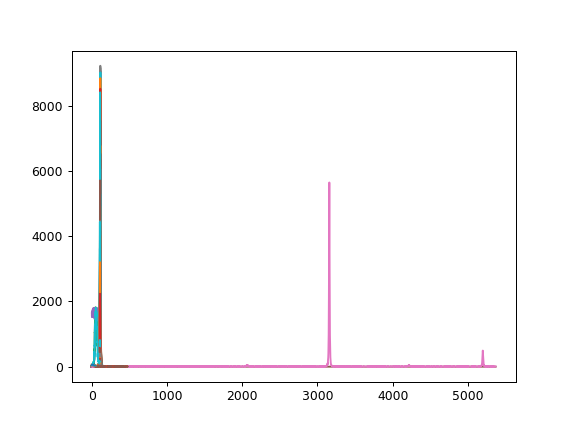

0
2
4
5
6
249
None


<IPython.core.display.Javascript object>


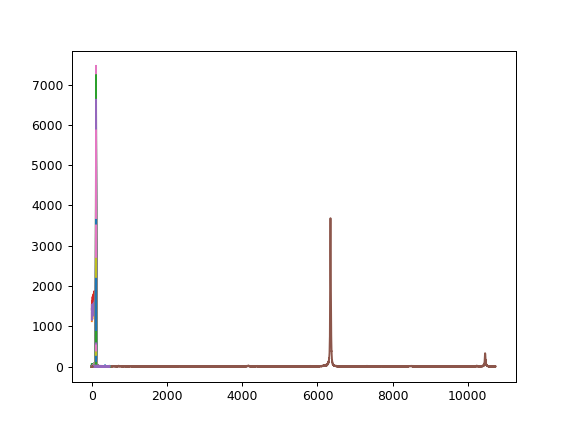

1
3
4
5
None


<IPython.core.display.Javascript object>


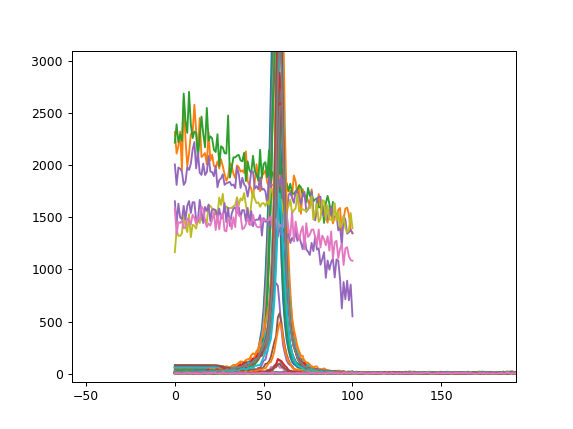

21
22
24
28
30
54
56
57
None


<IPython.core.display.Javascript object>


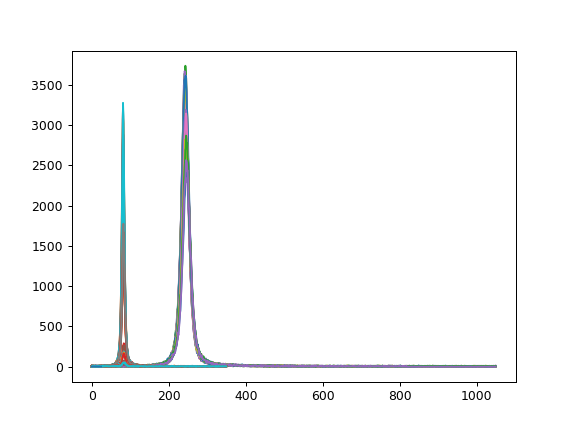

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
None


<IPython.core.display.Javascript object>


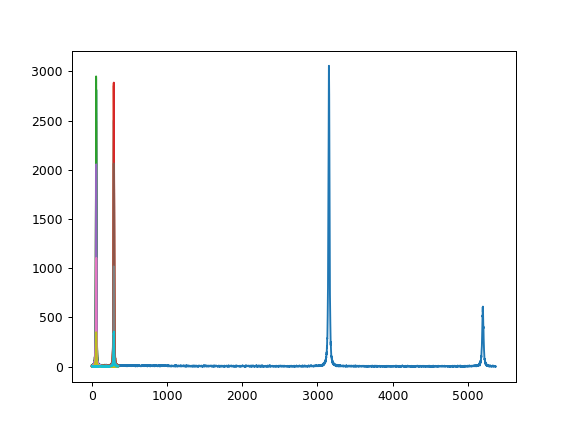

0
None


<IPython.core.display.Javascript object>


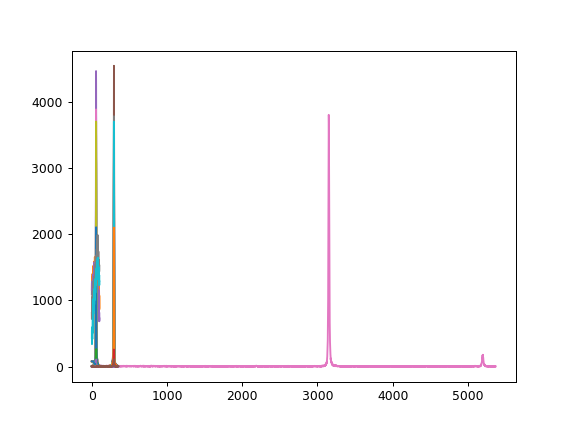

1
4
6
27
29
None


<IPython.core.display.Javascript object>


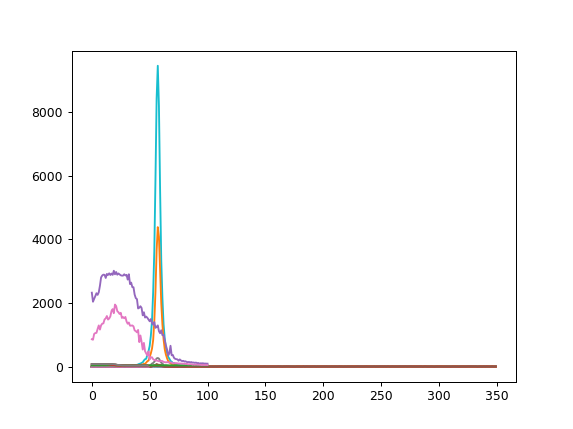

34
None


<IPython.core.display.Javascript object>


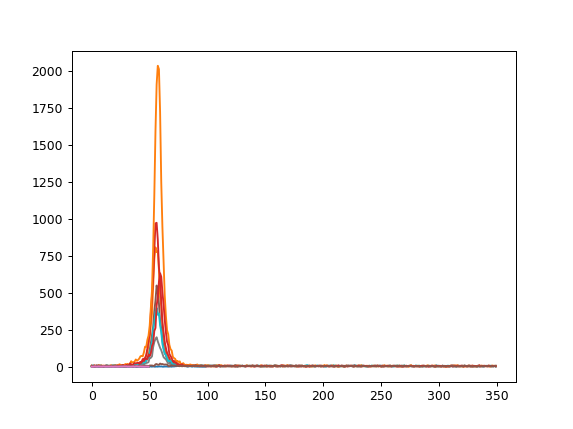

None


In [22]:
# TODO, plot en angles avant de faire les manip de netoyage...

def bad(intensities: List[ndarray]) -> int:
    for i, intensity in enumerate(intensities):
        l = len(intensity)
        if l > 48 and intensity[48] > 1000:
            print(i)
        if l > 1000:
            print(i)

for r in res:
    fig, ax = subplots()
    phis, chis, sums = r
    print(bad(sums))
    for p in sums:
        ax.plot(p)
show()

<IPython.core.display.Javascript object>


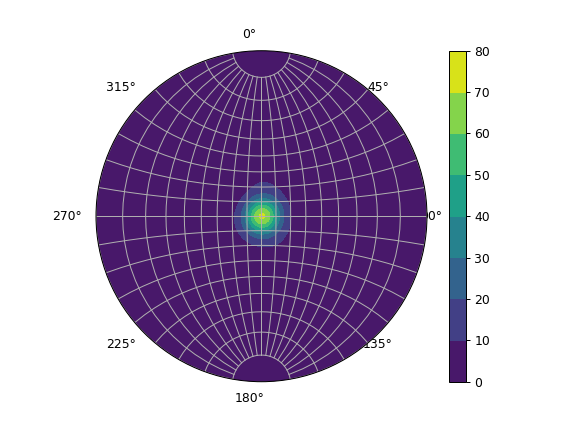

<IPython.core.display.Javascript object>


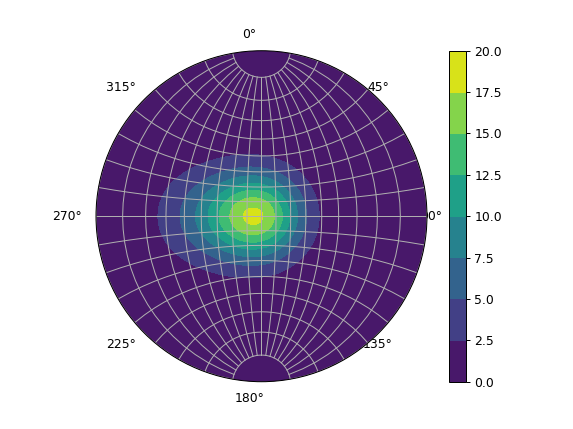

<IPython.core.display.Javascript object>


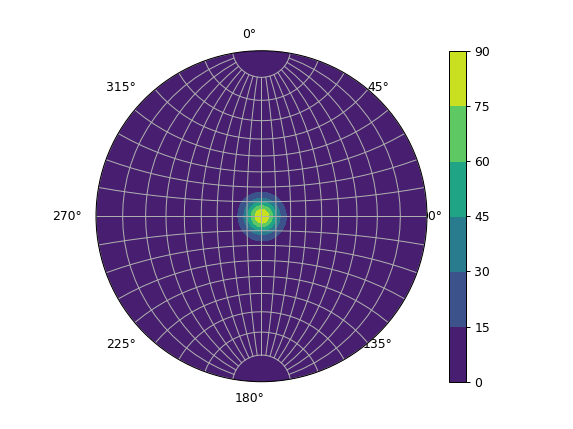

<IPython.core.display.Javascript object>


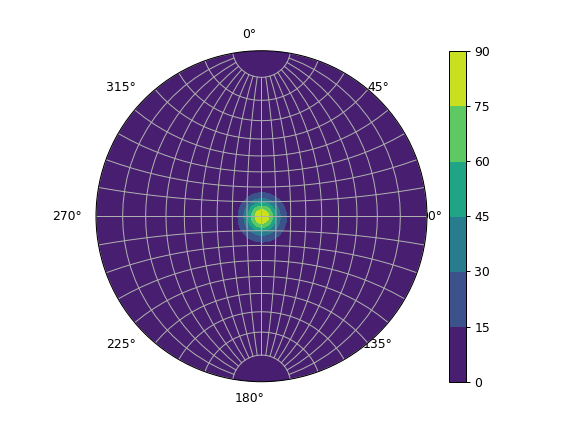

<IPython.core.display.Javascript object>


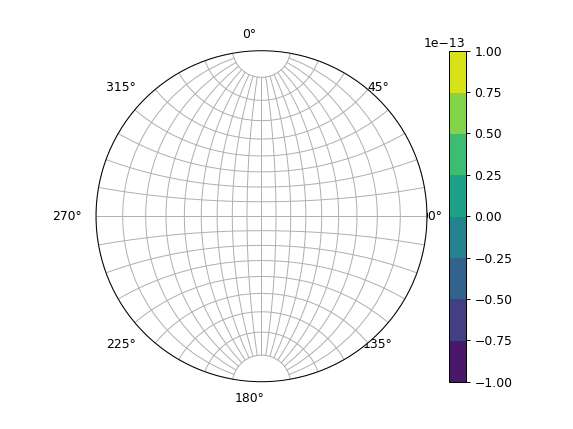

/usr/lib/python3/dist-packages/mplstereonet/contouring.py:43: RuntimeWarning: invalid value encountered in less
  totals[totals < 0] = 0
/usr/lib/python3/dist-packages/matplotlib/contour.py:1514: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/lib/python3/dist-packages/matplotlib/contour.py:1515: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


<IPython.core.display.Javascript object>


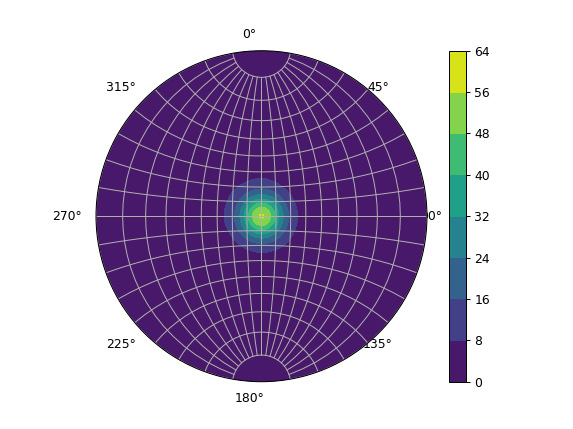

<IPython.core.display.Javascript object>


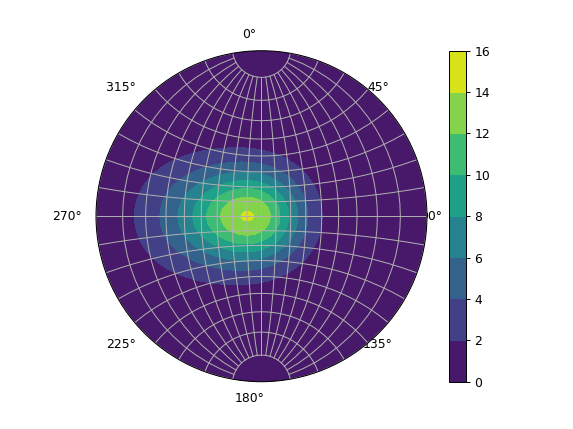

<IPython.core.display.Javascript object>


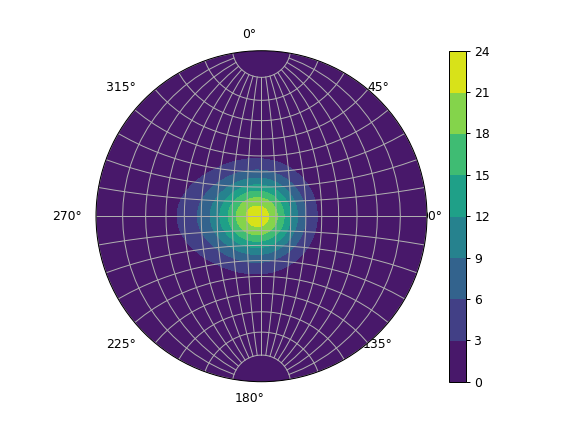

<IPython.core.display.Javascript object>


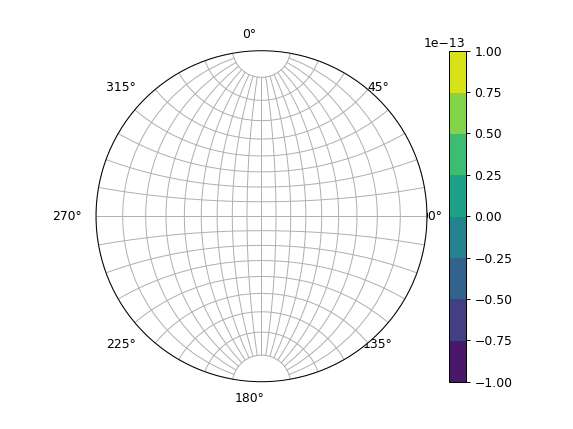

<IPython.core.display.Javascript object>


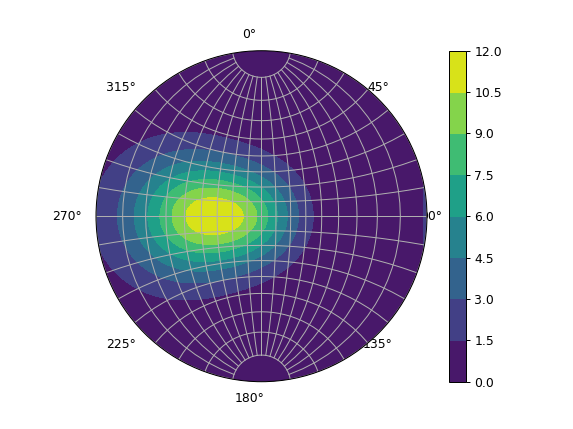

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import mplstereonet

for i, r in enumerate(res):
    fig, ax = mplstereonet.subplots(projection='equal_angle')

    phis, chis, sums = r
    w = array([a.sum() for a in sums])
    cax = ax.density_contourf(phis, chis, measurement='poles', weights=w)

    #ax.pole(phis, chis)
    ax.grid(True)
    fig.colorbar(cax)
    fig.savefig("/tmp/pole_{}.png".format(i))
    plt.show()
